# Faster R-Cnn Predictor 

In [1]:
import os
import cv2
import time
import argparse
from detector import DetectorTF2
import numpy as np 

def DetectImagesFromFolder(detector, images_dir, save_output=True, output_dir='output/'): 
	result = [] 

	for dir in os.scandir(images_dir): 
		if dir.is_dir():
			for file in os.scandir(dir.path): 
				_, file_extension = os.path.splitext(file.path)
				if file.is_file() and file_extension in [".png", ".jpg", ".jpeg"]: 
					image = cv2.imread(file.path)                
					det_boxes = detector.DetectFromImage(image) 
					image_detections = detector.DisplayDetections(image, det_boxes)

					if save_output:
						ug_out = os.path.join(output_dir, dir.name) 
						if not os.path.isdir(ug_out): 
							os.mkdir(ug_out)

						img_out = os.path.join(ug_out, file.name)
						if cv2.imwrite(img_out, image_detections): 
							for idx in range(len(det_boxes)): 
								result.append({
									"UrunGrubu": dir.name, 
									"File" : file.name, 
									"count": idx,
									"x_min": det_boxes[idx][0],
									"y_min": det_boxes[idx][1],
									"x_max": det_boxes[idx][2],
									"y_max": det_boxes[idx][3],
									"score": str(np.round(det_boxes[idx][-1], 4))
								})
	return result

In [2]:
detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    path_to_labelmap="../trained_model/frozen_model_1/labelmap.pbtxt",
    threshold=0.50
)

In [3]:
images_dir = "E:/datasets/IMG_all/train/"
res = DetectImagesFromFolder(detector, images_dir, output_dir="E:/datasets/IMG_all/out/")

In [6]:
import pandas as pd 
pd.DataFrame(res).to_csv("../data/detections_result_faster_rcnn.csv")

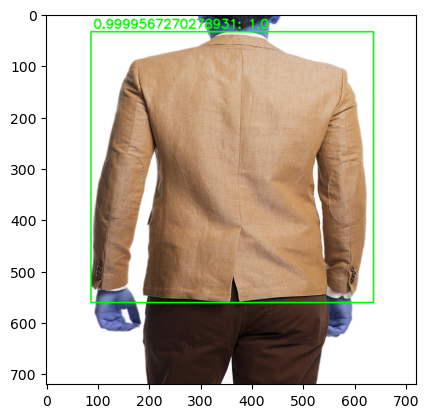

In [12]:
import matplotlib.pyplot as plt 

img = cv2.imread("../data/IMG_all/train/CEKET/6.png")
det_boxes = detector.DetectFromImage(img)
image_detections = detector.DisplayDetections(img, det_boxes)
plt.imshow(image_detections)

# Yolo Predictor 

In [2]:
import tensorflow as tf 
model = tf.keras.models.load_model('../trained_model/YOLOv3_model_v2/')

In [3]:
# bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
# class_ind = int(bbox[5]) 
# classes[class_ind]

import utils
import cv2 
from config import cfg
import os 
import numpy as np 

def inference(model: tf.keras.models.Model, path_to_image: str, dataset_name: str, cls: str, config: cfg, SCORE_THRESHOLD = 0.7, IOU_THRESHOLD = 0.5): 
    INPUT_SIZE = config.TEST.INPUT_SIZE

    image = cv2.imread(path_to_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_size = image.shape[:2]
    image_data = utils.image_preporcess(np.copy(image), [INPUT_SIZE, INPUT_SIZE])
    image_data = image_data[np.newaxis, ...].astype(np.float32) # (1, width, height, 3)

    pred_bbox = model.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox, image_size, INPUT_SIZE, SCORE_THRESHOLD)
    bboxes = utils.nms(bboxes, IOU_THRESHOLD, method='nms')

    image_with_detections = utils.draw_bbox(image, bboxes)
    image_with_detections = cv2.cvtColor(image_with_detections, cv2.COLOR_RGB2BGR)

    # If image size is too big then resize the image for display purposes
    display_shape = (image_size[1], image_size[0])
    if image_size[0] > 1500 or image_size[1] > 1500:
        display_shape = (int(image_size[1]/4), int(image_size[0]/4))

    image_with_detections = cv2.resize(image_with_detections, display_shape)

    ds_dir = dataset_name
    if not os.path.isdir(ds_dir):
        os.mkdir(ds_dir)
    
    ds_dir = os.path.join(ds_dir, cls)
    if not os.path.isdir(ds_dir):
        os.mkdir(ds_dir)

    if cv2.imwrite(os.path.join(ds_dir, os.path.split(path_to_image)[1]), image_with_detections):
        return bboxes
    else:
        return None 
    

In [3]:
""" inference(
    model=model, 
    dataset_name="deneme",
    path_to_image="C:/Users/melih.kacaman/projects_analytics/yolov3/yolov3_fashion_detection/custom_inputs/test_object_det_with_paths/TAKIM ELBISE/217.jpg", 
    cls="kafana",
    config=cfg, 
    SCORE_THRESHOLD=0.1
) """

' inference(\n    model=model, \n    dataset_name="deneme",\n    path_to_image="C:/Users/melih.kacaman/projects_analytics/yolov3/yolov3_fashion_detection/custom_inputs/test_object_det_with_paths/TAKIM ELBISE/217.jpg", \n    cls="kafana",\n    config=cfg, \n    SCORE_THRESHOLD=0.1\n) '

In [5]:
def group_inference(images_dir:str, inference, output_dir: str, threshold=0.5): 
	result = [] 
	errors = []  

	for dir in os.scandir(images_dir): 
		if dir.is_dir():
			for file in os.scandir(dir.path): 
				_, file_extension = os.path.splitext(file.path)
				if file.is_file() and file_extension in [".png", ".jpg", ".jpeg"]: 
					
					ch = os.path.join(output_dir, dir.name)
					ch = os.path.join(ch, file.name)
					if os.path.isfile(ch): 
						print(f"already exist {file.path}")
						continue

					try:
						bbox = inference(
							model=model,
							dataset_name=output_dir,
							path_to_image=file.path,
							cls=dir.name,
							config=cfg,
							SCORE_THRESHOLD=threshold, 
							IOU_THRESHOLD = 0.4
						)

						if bbox is not None: 
							for idx in range(len(bbox)): 
								result.append({
									"UrunGrubu": dir.name, 
									"File" : file.name, 
									"count": idx,
									"x_min": bbox[idx][0],
									"y_min": bbox[idx][1],
									"x_max": bbox[idx][2],
									"y_max": bbox[idx][3],
									"score": str(np.round(bbox[idx][4], 4))
								})
					except: 
						errors.append(file.name)		
	return result, errors				

In [6]:
res = group_inference(images_dir="E:/datasets/IMG_all/train/", inference=inference, output_dir="E:/datasets/IMG_all/yolo_out/", threshold=0.35)

already exist E:/datasets/IMG_all/train/CEKET\1.png
already exist E:/datasets/IMG_all/train/CEKET\100.png
already exist E:/datasets/IMG_all/train/CEKET\10013.png
already exist E:/datasets/IMG_all/train/CEKET\10018.png
already exist E:/datasets/IMG_all/train/CEKET\10020.png
already exist E:/datasets/IMG_all/train/CEKET\10024.png
already exist E:/datasets/IMG_all/train/CEKET\10026.png
already exist E:/datasets/IMG_all/train/CEKET\10033.png
already exist E:/datasets/IMG_all/train/CEKET\10034.png
already exist E:/datasets/IMG_all/train/CEKET\10049.png
already exist E:/datasets/IMG_all/train/CEKET\10056.png
already exist E:/datasets/IMG_all/train/CEKET\10071.png
already exist E:/datasets/IMG_all/train/CEKET\10081.png
already exist E:/datasets/IMG_all/train/CEKET\10085.png
already exist E:/datasets/IMG_all/train/CEKET\1009.png
already exist E:/datasets/IMG_all/train/CEKET\10105.png
already exist E:/datasets/IMG_all/train/CEKET\10108.png
already exist E:/datasets/IMG_all/train/CEKET\10118.png